In [62]:
import os
import numpy as np
import open3d as o3d
import pypcd4
from matplotlib import pyplot as plt

import plotly.io as pio
pio.renderers.default = "iframe"

In [ ]:
# Загрузка облака

In [58]:
pcd_path = 'data/points.pcd'

In [59]:
pc = pypcd4.PointCloud.from_path(pcd_path)

In [60]:
pc.fields

('x', 'y', 'z', 'intensity')

In [ ]:
# Интенсивоность ноль в исходнике у всех точек, про нее можно забыть

In [64]:
points = pc.numpy()

points.shape
# (1000, 3)

(9668627, 4)

In [71]:
p_min = points[:, 2].min()

In [72]:
# Нормализуем Z (камера на высоте 1.6 метров, минимум Z = 0)
points[:, 2] = points[:, 2] - p_min - 1.6

In [74]:
points[:, 2].max()

np.float32(64.798195)

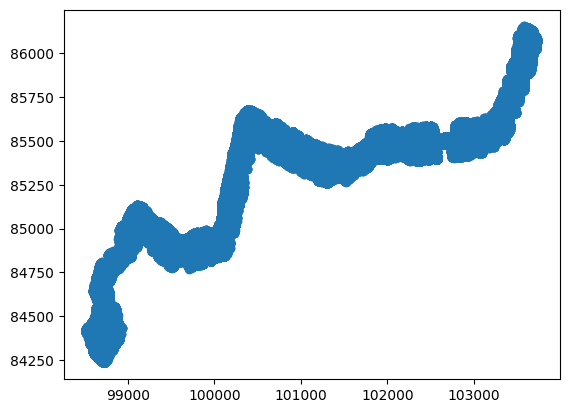

In [107]:
# Смотрим BEV
plt.scatter(points[:, 0], points[:, 1])

In [66]:
from scipy.spatial.distance import cdist
import numpy as np

# Предположим, что у нас есть точки в XY
xy = points[:, :2]  # (N, 2)
center_line
# Упорядочиваем точки по направлению движения (по увеличению x или по дистанции)
# Можно использовать алгоритм "greedy path" или просто сортировать по x
sorted_idx = np.argsort(xy[:, 0])  # если дорога идёт слева направо
xy_sorted = xy[sorted_idx]

# Теперь строим центральную линию — например, медиана по Y на каждом интервале X
# Разбиваем на бины по X и берем центр каждого бина
bin_size = 50  # пиксели или метры
x_bins = np.arange(xy_sorted[:, 0].min(), xy_sorted[:, 0].max(), bin_size)
center_line_x = []
center_line_y = []

for x_bin in x_bins:
    mask = (xy_sorted[:, 0] >= x_bin) & (xy_sorted[:, 0] < x_bin + bin_size)
    if np.any(mask):
        y_med = np.median(xy_sorted[mask, 1])
        center_line_x.append(x_bin + bin_size / 2)
        center_line_y.append(y_med)

center_line = np.column_stack([center_line_x, center_line_y])

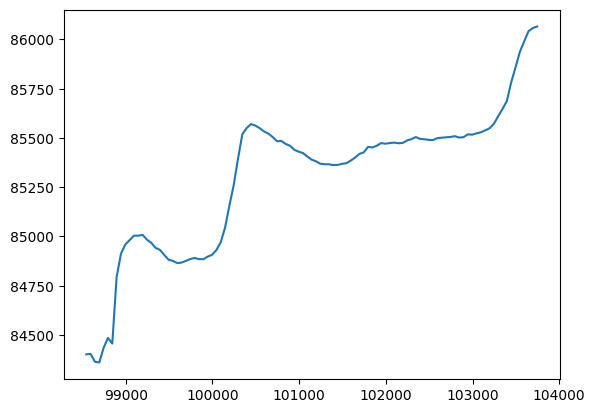

In [67]:
plt.plot(center_line[:, 0], center_line[:, 1])

In [85]:
len(center_line)

105

### режем на кубики вдоль траектории

In [92]:
def create_cubes_along_trajectory(points, center_line, cube_side, line_step, width_offset=150):
    cubes = []
    step = line_step # шаг вдоль траектории

    for i in range(0, len(center_line), step):
        # Берём текущий сегмент
        p0 = center_line[i]
        p1 = center_line[min(i + step, len(center_line)-1)]
        
        # Вектор направления
        dir_vec = p1 - p0
        dir_vec_norm = dir_vec / np.linalg.norm(dir_vec)
        
        # Перпендикулярный вектор (для ширины дороги)
        perp_vec = np.array([-dir_vec_norm[1], dir_vec_norm[0]])  # поворот на 90°
        
        # Границы куба вдоль дороги
        half_width = width_offset  # например, 10 м
        half_cube = cube_side / 2
        
        # Определяем углы куба в плоскости XY
        corners = []
        for dx in [-half_cube, half_cube]:
            for dy in [-half_width, half_width]:
                corner = p0 + dx * dir_vec_norm + dy * perp_vec
                corners.append(corner)
        
        # Проецируем на Z: добавляем диапазон высот
        z_range = np.percentile(points[:, 2], [10, 90])  # или фиксированный диапазон
        z_min, z_max = z_range[0] - width_offset, z_range[1] + width_offset
        
        # Фильтруем точки внутри куба
        mask = np.zeros(len(points), dtype=bool)
        for j in range(len(points)):
            pt = points[j]
            # Проверяем, попадает ли точка в этот куб
            # Проекция на ось дороги
            proj = np.dot(pt[:2] - p0, dir_vec_norm)
            if abs(proj) > cube_side:
                continue
            # Поперечное смещение
            cross_dist = np.dot(pt[:2] - p0, perp_vec)
            if abs(cross_dist) > width_offset:
                continue
            if not (z_min <= pt[2] <= z_max):
                continue
            mask[j] = True
        
        # Сохраняем куб
        cube_points = points[mask]
        cubes.append(cube_points)
    
    return cubes

In [103]:
cubes = create_cubes_along_trajectory(points, center_line, cube_side=500, line_step=5, width_offset=150)

In [104]:
len(cubes)

21

In [105]:
cubes[1].shape

(790752, 4)

In [106]:
CUBES_PATH = 'data/cubes2'
for i, cube in enumerate(cubes):
    pc_current = pypcd4.PointCloud.from_xyzi_points(cube)
    np.save(os.path.join(CUBES_PATH, f"{i}.npy"), cube)
    pc_current.save(os.path.join(CUBES_PATH, f"{i}.pcd"))

In [ ]:
# Сохраненние для OpenPCDet
np_path = 'data/points.npy'

np.save(np_path, points) 

In [97]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cubes[0][:, :3])

In [98]:
def draw_pcd(pcd, voxel_size=5.0):
    pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
    pcd_down.paint_uniform_color([1, 0, 0])
    o3d.visualization.draw_plotly([pcd_down])
    # return pcd_down    

In [99]:
draw_pcd(pcd)

In [8]:
points = np.asarray(pcd.points, dtype=np.float32)

### Просмотр результатов

In [1]:
pwd

'/home/jovyan/work/lidar-clouds'

In [7]:
import numpy as np
from collections import Counter

data = np.load("data/opencdet_cubes/preds/sample_000000.npz")
labels = data["labels"]
counts = Counter(labels)
print("Количество объектов по классам:", counts)

Количество объектов по классам: Counter({np.int64(7): 56, np.int64(1): 45, np.int64(6): 20, np.int64(10): 12, np.int64(2): 8, np.int64(4): 8, np.int64(8): 6, np.int64(9): 5, np.int64(5): 2})


In [2]:
import numpy as np

data = np.load("data/opencdet_cubes/preds/sample_000000.npz")

print("Содержимое файла:", data.files)
print("points shape:", data["points"].shape)       # [N, 5]
print("boxes shape:", data["boxes"].shape)         # [M, 7]
print("scores shape:", data["scores"].shape)       # [M]
print("labels shape:", data["labels"].shape)       # [M]

# Пример первых строк:
print("\nТочки:\n", data["points"][:5])
print("\nБоксы:\n", data["boxes"][:5])
print("\nОценки:\n", data["scores"][:5])
print("\nМетки классов:\n", data["labels"][:5])


Содержимое файла: ['points', 'boxes', 'scores', 'labels']
points shape: (25873, 6)
boxes shape: (162, 9)
scores shape: (162,)
labels shape: (162,)

Точки:
 [[  0.         37.585938   13.734375    2.7363186   1.          0.       ]
 [  0.         50.78125   -35.429688   -3.4331303   1.          0.       ]
 [  0.        -41.289062  -23.234375   -2.1324406   1.          0.       ]
 [  0.         47.234375  -29.765625   -6.3444004   1.          0.       ]
 [  0.         53.90625    10.6640625  -6.122614    1.          0.       ]]

Боксы:
 [[-3.2925518e+01  4.0902405e+01  7.8163767e-01  4.9195342e+00
   2.0123630e+00  1.8200765e+00  2.3841703e+00 -2.3543038e+00
   2.2555175e+00]
 [-1.6762337e+01 -3.5439018e+01  1.7336796e-01  4.4939909e+00
   1.9413713e+00  1.7130262e+00 -1.3695323e+00 -2.1727812e-08
   7.5798490e-10]
 [ 1.9698692e+01  2.0395164e+01 -1.3911074e+00  4.4052725e+00
   1.8967279e+00  1.6488860e+00 -2.2804866e+00 -2.8055253e-02
  -8.1488326e-02]
 [-1.9804737e+01 -3.9664352e+01  

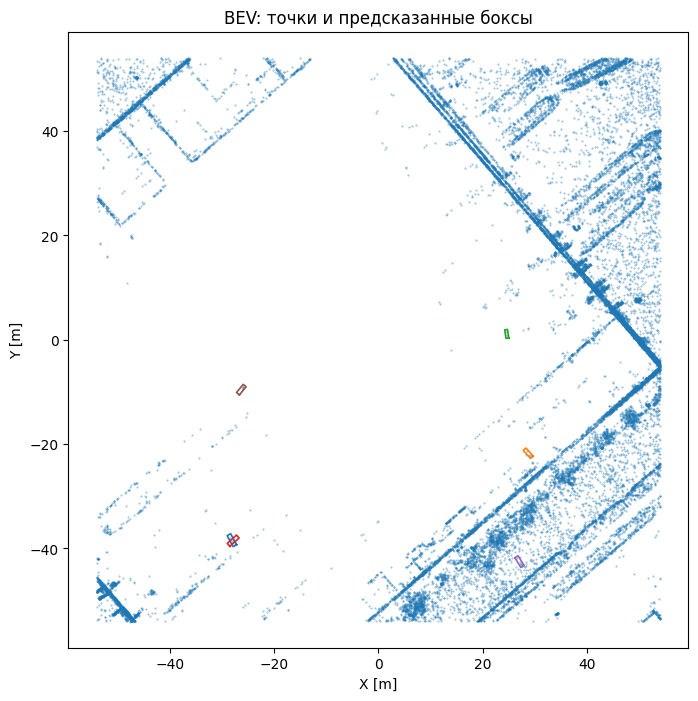

In [5]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("data/opencdet_cubes/preds/sample_000000.npz")

pts = data["points"][:, 1:3]  # (x,y) из [batch_idx, x, y, z, i]
boxes = data["boxes"]         # shape [M, 7+] (x,y,z,dx,dy,dz,yaw, [vx,vy])
scores = data.get("scores")
labels = data.get("labels")

# (опц.) фильтр по уверенности
min_score = 0.3
if scores is not None:
    keep = scores >= min_score
    boxes = boxes[keep]
    if labels is not None: labels = labels[keep]

def bev_corners_xy(x, y, dx, dy, yaw):
    # локальные углы прямоугольника вокруг (0,0)
    corners = np.array([
        [-dx/2, -dy/2],
        [ dx/2, -dy/2],
        [ dx/2,  dy/2],
        [-dx/2,  dy/2],
    ], dtype=np.float32)
    c, s = np.cos(yaw), np.sin(yaw)
    R = np.array([[c, -s],
                  [s,  c]], dtype=np.float32)
    rot = corners @ R.T
    rot[:, 0] += x
    rot[:, 1] += y
    return rot

plt.figure(figsize=(8, 8))
plt.scatter(pts[:,0], pts[:,1], s=0.2, alpha=0.5)  # без явных цветов

# берём только первые 7 компонентов (если их больше)
if boxes.size > 0:
    core = boxes[:, :7]  # x,y,z,dx,dy,dz,yaw
    for b in core:
        x, y, z, dx, dy, dz, yaw = b.tolist()
        poly = bev_corners_xy(x, y, float(dx), float(dy), float(yaw))
        # рисуем замкнутый многоугольник
        poly_closed = np.vstack([poly, poly[0]])
        plt.plot(poly_closed[:,0], poly_closed[:,1], linewidth=1.2)  # без явных цветов

plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis("equal")
plt.title("BEV: точки и предсказанные боксы")
plt.show()


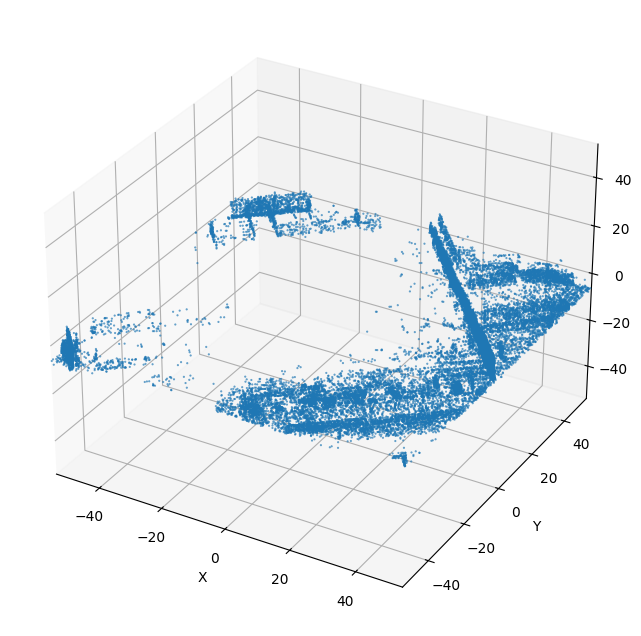

In [6]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("data/opencdet_cubes/preds/sample_000000.npz")
P = data["points"][:, 1:4]  # x,y,z

# при большом числе точек немного проредим для скорости
if len(P) > 300_000:
    P = P[::max(1, len(P)//300_000)]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(P[:,0], P[:,1], P[:,2], s=0.3, alpha=0.7)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

# равные масштабы
ranges = P.max(0) - P.min(0)
m = P.min(0) + ranges/2
r = ranges.max()/2
ax.set_xlim(m[0]-r, m[0]+r)
ax.set_ylim(m[1]-r, m[1]+r)
ax.set_zlim(m[2]-r, m[2]+r)
plt.show()


In [8]:
import numpy as np
import open3d as o3d

data = np.load("data/opencdet_cubes/preds/sample_000000.npz")
points = data["points"][:, 1:4]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
o3d.io.write_point_cloud("points.ply", pcd)

True